In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = "C:\\Users\\gaura\\Documents\\GitHub\\Scaler-Projects\\Natural Language Processing\\Project\\Twitter_NER_NLP\\data\\Datasets\\wnut_16.txt.conll"

In [3]:
test_data = "C:\\Users\\gaura\\Documents\\GitHub\\Scaler-Projects\\Natural Language Processing\\Project\\Twitter_NER_NLP\\data\Datasets\\wnut_16test.txt.conll"

In [4]:
def get_name_entity_values(data_path):
    """
    This function will read file and generate NER DataFrame from it.
    """
    with open(data_path,'r') as f:
        data = f.readlines()
    text,entity=[],[]
    for val in data:
        if(len(val.split('\t'))==1):
            continue
        temp_vals = val.split('\t')
        temp_text, temp_ner = temp_vals[0],temp_vals[1].split("\n")[0]
        text.append(temp_text)
        entity.append(temp_ner)
    df = pd.DataFrame()
    df['Text'] = text
    df['Entity'] = entity
    f.close()
    return df

train_df = get_name_entity_values(data_path)
test_df = get_name_entity_values(test_data)

In [5]:
#pd.set_option('display.max_rows', None)

In [6]:
train_df.head()

,Text,Entity
0,@SammieLynnsMom,O
1,@tg10781,O
2,they,O
3,will,O
4,be,O


In [7]:
# #pd.set_option('display.max_rows', None)
train_df = train_df.loc[train_df['Entity']!='O']

In [8]:
train_df.shape

(2462, 2)

In [9]:
train_df.head()

,Text,Entity
17,GA,B-geo-loc
25,Disney,B-facility
26,world,I-facility
41,Disney,B-facility
42,World,I-facility


In [10]:
train_df.describe()

,Text,Entity
count,2462,2462
unique,1693,20
top,The,B-person
freq,39,449


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2462 entries, 17 to 46426
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2462 non-null   object
 1   Entity  2462 non-null   object
dtypes: object(2)
memory usage: 57.7+ KB


In [12]:
train_df.isna().sum()

Text      0
Entity    0
dtype: int64

# Data Exploration

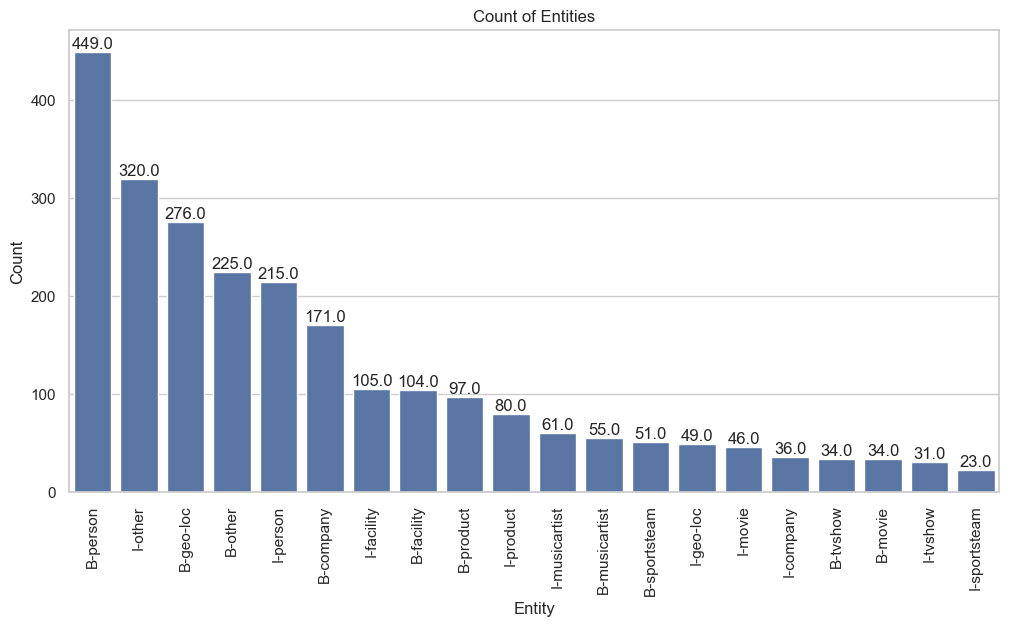

In [13]:
# Create the countplot
sns.set(style="whitegrid")  # Optional: Set a style
plt.figure(figsize=(12, 6))  # Optional: Set the figure size

sns.countplot(data=train_df, x='Entity', order=train_df['Entity'].value_counts().index)

# Add values above the bars
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Customize labels and title
plt.xlabel('Entity')
plt.ylabel('Count')
plt.title('Count of Entities')

plt.xticks(rotation=90)

# Show the plot
plt.show()


In [14]:
from sklearn.model_selection import train_test_split as tts 
from sklearn.preprocessing import LabelEncoder

In [15]:
X = train_df['Text']
encode = LabelEncoder().fit(train_df['Entity'],)
Y = encode.transform(train_df['Entity'])

In [16]:
from sklearn.utils.class_weight import compute_class_weight

In [17]:
weights = compute_class_weight(class_weight="balanced",classes=np.unique(Y), y=Y)
weights  =np.round(weights,2)
weights

array([0.72, 1.18, 0.45, 3.62, 2.24, 0.55, 0.27, 1.27, 2.41, 3.62, 3.42,
       1.17, 2.51, 2.68, 2.02, 0.38, 0.57, 1.54, 5.35, 3.97])

In [18]:
weight_map = {vals:weight for vals,weight in zip(np.unique(Y),weights)}

In [19]:
weight_map

{0: 0.72,
 1: 1.18,
 2: 0.45,
 3: 3.62,
 4: 2.24,
 5: 0.55,
 6: 0.27,
 7: 1.27,
 8: 2.41,
 9: 3.62,
 10: 3.42,
 11: 1.17,
 12: 2.51,
 13: 2.68,
 14: 2.02,
 15: 0.38,
 16: 0.57,
 17: 1.54,
 18: 5.35,
 19: 3.97}

In [20]:
xtrain,xtest,ytrain,ytest = tts(X,Y,test_size=0.25,random_state=41)

In [21]:
print(f'train_shape : {xtrain.shape} , test_shape : {xtest.shape}, ytrain_shape:{ytrain.shape} , ytest_shape:{ytest.shape}')

train_shape : (1846,) , test_shape : (616,), ytrain_shape:(1846,) , ytest_shape:(616,)


# Configuration

In [22]:
n_classes = len(set(ytrain))
max_words = len(set(xtrain))
max_len = 1000
print(f'n_classes : {n_classes} , max_words : {max_words} , max_len : {max_len}')

n_classes : 20 , max_words : 1331 , max_len : 1000


In [23]:
from tensorflow.keras.layers import GRU, Embedding,GlobalAveragePooling1D, Dense, Dropout, TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from gensim.models import Word2Vec

In [24]:
# Vocabulary size and number of words in a sequence.
vocab_size = max_words+1
sequence_length = 100

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return lowercase
# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [25]:
text_ds = xtrain.map(lambda x: x)
vectorize_layer.adapt(text_ds)

In [26]:
test_txt  = xtest.map(lambda x: x)
vectorize_layer.adapt(test_txt)
test_txt_vectors = vectorize_layer(test_txt)

In [27]:
txt_vectors = vectorize_layer(text_ds)

In [28]:
for x,vec in zip(xtest[:5],test_txt_vectors[:5]):
    print(f'{x} -> {vec}')


Chiles -> [406   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
St -> [13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
Elliot -> [363   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  

# Model using GRU -> Trying to replicate NER using clasification anology

In [29]:
embedding_dim=100
model = Sequential([
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(32,activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dense(n_classes,activation='softmax')
])

model.compile(optimizer='NAdam',loss='sparse_categorical_crossentropy',metrics=['Accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         133200    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [31]:
hist = model.fit(txt_vectors,ytrain,validation_split=0.2,batch_size=32,epochs=10,verbose=1)

Epoch 1/10
47/47 [==============================] - 3s 13ms/step - loss: 2.8934 - Accuracy: 0.1192 - val_loss: 2.6718 - val_Accuracy: 0.1568
Epoch 2/10
47/47 [==============================] - 0s 9ms/step - loss: 2.6809 - Accuracy: 0.1850 - val_loss: 2.6356 - val_Accuracy: 0.1892
Epoch 3/10
47/47 [==============================] - 0s 9ms/step - loss: 2.6637 - Accuracy: 0.1768 - val_loss: 2.6244 - val_Accuracy: 0.1892
Epoch 4/10
47/47 [==============================] - 0s 9ms/step - loss: 2.6672 - Accuracy: 0.1755 - val_loss: 2.6255 - val_Accuracy: 0.1892
Epoch 5/10
47/47 [==============================] - 0s 9ms/step - loss: 2.6537 - Accuracy: 0.1802 - val_loss: 2.6419 - val_Accuracy: 0.1892
Epoch 6/10
47/47 [==============================] - 0s 9ms/step - loss: 2.6575 - Accuracy: 0.1782 - val_loss: 2.6306 - val_Accuracy: 0.1892
Epoch 7/10
47/47 [==============================] - 0s 8ms/step - loss: 2.6574 - Accuracy: 0.1795 - val_loss: 2.6291 - val_Accuracy: 0.1892
Epoch 8/10
47/47 [=

# Model Performance Visualization

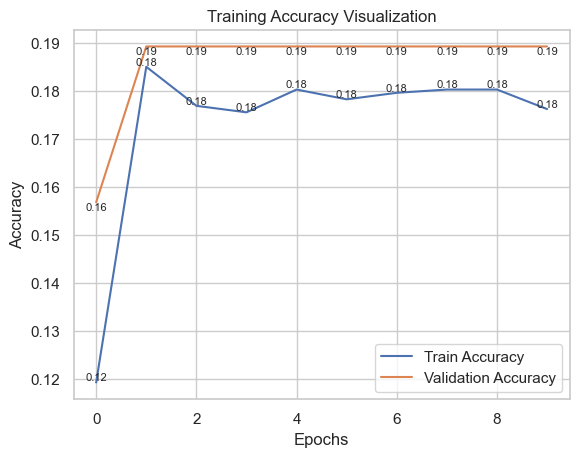

In [32]:
import matplotlib.pyplot as plt

# Assuming you have already defined 'hist' containing the training history
plt.plot(hist.history['Accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_Accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training Accuracy Visualization")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)

# Adding values to the graph
for epoch, acc in enumerate(hist.history['Accuracy']):
    plt.text(epoch, acc, f"{acc:.2f}", ha='center', va='bottom', fontsize=8)

for epoch, val_acc in enumerate(hist.history['val_Accuracy']):
    plt.text(epoch, val_acc, f"{val_acc:.2f}", ha='center', va='top', fontsize=8)

plt.show()


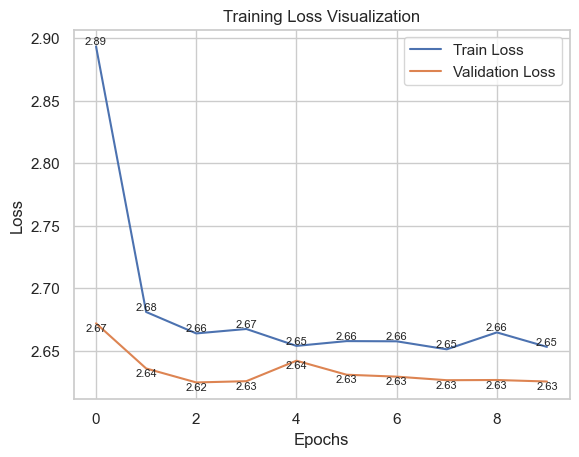

In [33]:
import matplotlib.pyplot as plt

# Assuming you have already defined 'hist' containing the training history
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training Loss Visualization")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# Adding values to the graph
for epoch, loss in enumerate(hist.history['loss']):
    plt.text(epoch, loss, f"{loss:.2f}", ha='center', va='bottom', fontsize=8)

for epoch, val_loss in enumerate(hist.history['val_loss']):
    plt.text(epoch, val_loss, f"{val_loss:.2f}", ha='center', va='top', fontsize=8)

plt.show()


In [36]:
import tensorflow_hub as hub
import tensorflow_text as text


In [37]:
class Getembed:
    def get_embeddings(self,sentences):
        '''return BERT-like embeddings of input text
          Args:
            - sentences: list of strings
          Output:
            - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
          '''
        encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
        preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
    
    
        preprocessed_text = preprocessor(sentences)
        return encoder(preprocessed_text)

In [39]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
embed = Getembed()
x = embed.get_embeddings(i)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(n_classes, activation='softmax', name="output")(x)

model_bert = tf.keras.Model(i, x)

In [40]:
model_bert.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['Accuracy'])